In [0]:
from keras import backend as K
import keras
from keras.utils import Sequence
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import resnet, mobilenet
from keras.layers.merge import concatenate
from keras import layers
import pandas as pd
import glob
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('INFO')
import cv2 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# %run readandsubmit.ipynb

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def make_rle(ar): # must be numpy array
    ar = ar.flatten()
    new_ar = list()
    
    flag = False
    for inx,val in enumerate(ar):
        if val != 0:
            if not flag:
                new_ar.append(inx+1) 
                flag = True
        else:
            if flag:
                flag = False
                new_ar.append(inx-new_ar[-1]+1)
    if flag:
        new_ar.append(ar.shape[0] - new_ar[-1] + 1)
        
    return new_ar  

__Binary classification__

In [0]:
def readImgNames(train=True):
    names = list()
    loc = "train_images/*" if train else "/content/drive/My Drive/Colab Notebooks/test_images/*"
    return [i[i.rfind("/")+1:] for i in glob.glob(loc)]

In [0]:
names = readImgNames(train=False)

In [0]:
df = pd.DataFrame(names,columns=["ImageId"])

In [0]:
def createTestFlow():
    return ImageDataGenerator().flow_from_dataframe(
        df,
        directory='/content/drive/My Drive/Colab Notebooks/resized_test',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=40,
        shuffle=False
    )

In [0]:
test = createTestFlow()

Found 5506 validated image filenames.


In [0]:
def build_model():
    mobilenet_ = mobilenet.MobileNet(
        include_top=False,
        input_shape=(256,256,3),
        weights='imagenet',
    )
    
    model = Sequential()
    model.add(mobilenet_)
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer="adam",
        metrics=['accuracy']
    )
    
    return model

model = build_model()

In [0]:
model.load_weights("/content/drive/My Drive/Colab Notebooks/model.h5")

In [0]:
y_test = model.predict_generator(
    test,
    steps=len(test),
    verbose=1
)

In [0]:
df["hasFraud"] =  [1 if inx > 0.5 else 0 for inx in y_test]
df_frauds = df[df["hasFraud"] == 1]

__Now U-NET test__

In [0]:
pos = pd.read_csv("/content/drive/My Drive/Colab Notebooks/pics.csv")
df_frauds = df[df["ImageId"].isin(pos["ImageId"])]
df_frauds.reset_index(inplace=True)
df_frauds.drop("index",inplace=True,axis=1)

In [0]:
def build_model(input_shape=(256,1600,3)):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

In [0]:
class Generator(Sequence):
  def __init__(self,df, list_IDs, path, batch_size=1, dim=(256,1600), n_channels=3,n_classes=10, shuffle=True, isTrain=True):
      self.df = df
      self.dim = dim
      self.batch_size = batch_size
      self.list_IDs = list_IDs
      self.n_channels = n_channels
      self.n_classes = n_classes
      self.shuffle = shuffle
      self.path = path
      self.isTrain = isTrain
      self.on_epoch_end()
  def __len__(self):
      return int(np.floor(len(self.list_IDs) / self.batch_size))
  def on_epoch_end(self):
      self.indexes = np.arange(len(self.list_IDs))
      if self.shuffle == True:
          np.random.seed(42)
          np.random.shuffle(self.indexes)
  def __getitem__(self, index):
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
      if self.isTrain:
          X, y = self.__data_generation(list_IDs_temp)
          return X, y

      else:
          X = self.__get_X(list_IDs_temp)
          return X

  def __data_generation(self, list_IDS):
      X = np.empty((self.batch_size, *self.dim, self.n_channels))
      y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)

      for inx, ID in enumerate(list_IDS):
        im_name = self.df["ImageId"].iloc[ID]
        X[inx,] = cv2.imread(self.path+im_name)

        im_df = self.df[self.df['ImageId'] == im_name]
        masks = build_masks(im_df)
            
        y[inx, ] = masks

      return X, y
  def __get_X(self,list_IDS):
      X = np.empty((self.batch_size, *self.dim, self.n_channels))
      for inx, ID in enumerate(list_IDS):
        im_name = self.df["ImageId"].loc[ID]
        X[inx,] = cv2.imread(self.path+im_name)
        
      return X
   

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [0]:
model = build_model()
model.load_weights("/content/drive/My Drive/Colab Notebooks/UNETbestweights.h5")

In [0]:
res = np.empty((2883,256,1600,4),dtype=np.uint8)
for itr in range(0,df_frauds.shape[0], 200):
  generator = Generator(
    list_IDs = df_frauds.index[itr:itr+200],
    df=df_frauds.iloc[itr:itr+200],
    n_classes=4,
    isTrain=False,
    shuffle=False,
    path="/content/drive/My Drive/Colab Notebooks/test_images"
  )
  if itr != 2800:
    res[itr:itr+200,] = model.predict_generator(generator)
  else:
    res[itr:itr+83,] = model.predict_generator(generator)


In [0]:
no_frauds = df[~df["ImageId"].isin(df_frauds["ImageId"].unique())]

In [0]:
res_df = pd.DataFrame(columns=["ImageId"])
i = 0
for inx,picture in enumerate(res):
  for cls in range(0,4):
    rle = make_rle(picture[:,:,cls])
    if rle != []:
      print(1)
  i+=1
  if i == 1500:
    break

KeyboardInterrupt: ignored

In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Mask_RCNN")
! python3 setup.py install
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN, log
from mrcnn import visualize, utils

In [0]:
class SeverstalConfig(Config):
    NAME = "severstal"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 4 + 1

    STEPS_PER_EPOCH = 100

    DETECTION_MIN_CONFIDENCE = 0.7

    SAVE_BEST_ONLY = True
    
severstal_config = SeverstalConfig()

In [0]:
# initialiazing model
model = MaskRCNN(mode='inference', config=severstal_config, model_dir='modeldir')

model.load_weights('/content/drive/My Drive/Colab Notebooks/bestweightsRCNN.h5', 
                   by_name=True, 
                   exclude=['mrcnn_bbox_fc',
                            'mrcnn_class_logits', 
                            'mrcnn_mask',
                            'mrcnn_bbox'])

In [0]:
df_res = pd.DataFrame(columns=["ImageId","EncodedPixels","ClassId"])

Processing 1 images
image                    shape: (256, 1600, 3)        min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


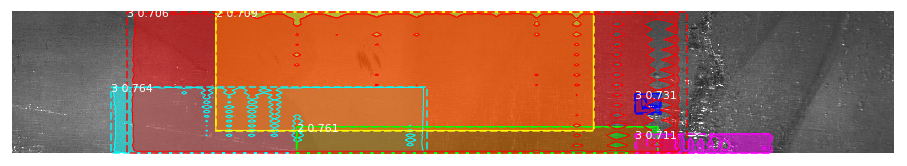

In [0]:
for img in df_frauds["ImageId"]:
  pic = cv2.imread(f"/content/drive/My Drive/Colab Notebooks/test_images/{img}")
  results = model.detect([pic], verbose=1)
  # res = make_rle(pic)
  r = results[0]
  visualize.display_instances(pic, r['rois'], r['masks'], r['class_ids'], 
                              [1,2,3,4], r['scores'], colors=None)
  break

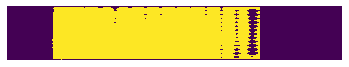

In [0]:
# plt.figure(figsize=(40,40))
def make_segmentation_mask(image, mask):
    img = image.copy()
    img[:,:,0] *= mask
    img[:,:,1] *= mask
    img[:,:,2] *= mask
    plt.axis('off')
    fig=plt.imshow(mask,interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

mask = res[0]['masks'][:,:,5]
make_segmentation_mask(pic, mask)